In [4]:
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
import string
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load stopwords
stop_words = set(stopwords.words('english'))

# Function to calculate additional features
def calculate_text_features(text):
    words = text.split()
    # Punctuation Count
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    # Digit Count
    digit_count = sum(1 for char in text if char.isdigit())
    # POS Tagging
    pos_tags = pos_tag(word_tokenize(text))
    noun_count = sum(1 for word, tag in pos_tags if tag.startswith('NN'))
    # Exclamation Count
    exclamation_count = text.count('!')
    # Question Count
    question_count = text.count('?')
    # Title Word Count
    title_word_count = sum(1 for word in words if word.istitle())
    
    return (punctuation_count, digit_count, noun_count,
            exclamation_count, question_count, title_word_count)

# Load your dataset
# Assuming the dataset is in a CSV file with columns 'text' and 'label'
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to numerical data using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Calculate additional features for training data
X_train_features = np.array([calculate_text_features(text) for text in X_train])
# Calculate additional features for testing data
X_test_features = np.array([calculate_text_features(text) for text in X_test])

# Combine CountVectorizer output with additional features
X_train_combined = hstack([X_train_vect, X_train_features])
X_test_combined = hstack([X_test_vect, X_test_features])

# Define the Gradient Boosting model with grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_combined, y_train)

# Print the best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [1]:
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
import string
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
# Load stopwords
stop_words = set(stopwords.words('english'))

from features import calculate_text_features_gbc_tf as calculate_text_features

# Load your dataset
# Assuming the dataset is in a CSV file with columns 'text' and 'label'
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to numerical data using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Calculate additional features for training data
X_train_features = np.array([calculate_text_features(text) for text in X_train])
# Calculate additional features for testing data
X_test_features = np.array([calculate_text_features(text) for text in X_test])

# Combine CountVectorizer output with additional features
X_train_combined = hstack([X_train_vect, X_train_features])
X_test_combined = hstack([X_test_vect, X_test_features])

# Train the Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train_combined, y_train)


# Save the model to a .pkl file
joblib.dump((vectorizer,gbc_model), '../trained_models/GBC_TF.pkl')

# Make predictions
y_pred = gbc_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8433333333333334
Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.83      0.89       162
        fear       0.95      0.84      0.89       151
         joy       0.65      0.82      0.72       148
        love       0.88      0.91      0.89       143
     sadness       0.81      0.65      0.72       141
    surprise       0.86      0.99      0.92       155

    accuracy                           0.84       900
   macro avg       0.85      0.84      0.84       900
weighted avg       0.85      0.84      0.84       900



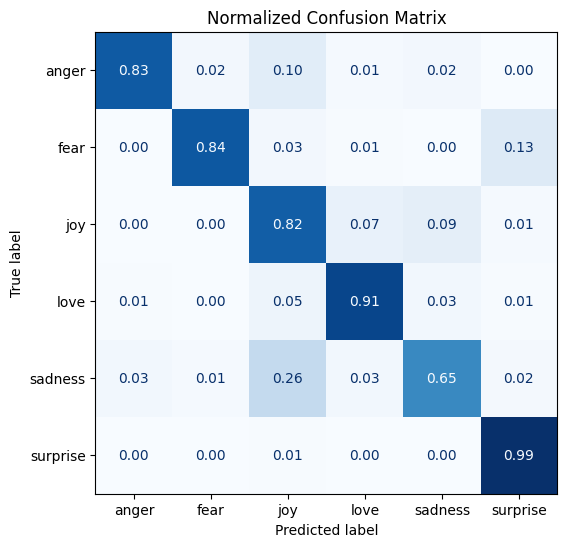

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_predicted, y_true, labels):
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Example usage
labels = df['label'].unique()  # Extract unique labels from the DataFrame
plot_confusion_matrix(y_pred, y_test, labels)


In [8]:
# import os

# # Define the directory and file names
# output_dir = '../python_models'
# notebook_filename = 'GBC_TF.ipynb'
# python_filename = notebook_filename.replace('.ipynb', '.py')

# # Ensure the output directory exists
# os.makedirs(output_dir, exist_ok=True)

# # Convert the notebook to a Python script
# !jupyter nbconvert --to script --output-dir {output_dir} {notebook_filename}

[NbConvertApp] Converting notebook GBC_TF.ipynb to script
[NbConvertApp] Writing 6922 bytes to ..\python_models\GBC_TF.py
